# The goal of this project is to correlate child abuse deaths with median household income by state.

## Extraction. Finding the data that might correlate and putting it into dataframes

In [1]:
# Initialization
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import dbconfig as cfg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as a3d

#### Dataset 1 comes from the Child Abuse Prevention and Treatment Act Reports, 2011-2015 found at https://www.propublica.org/datastore/dataset/child-abuse-prevention-and-treatment-act-reports-2011-2015


In [2]:
# Dataset 1 ends up as a spreadsheet
# 20191212-CAPTA-reports-2011-2015.xlsx
abuse_file = "./data/20191212-CAPTA-reports-2011-2015.xlsx"
abuse_df = pd.read_excel(abuse_file)
abuse_df.head()

,id,DBN,state,city_or_county_of_death,year_fy,age,gender,cause_of_death,services_provided,urls
0,1,AK-F-001,AK,-,2011,0,F,-,N,https://www.documentcloud.org/documents/599480...
1,2,AK-F-002,AK,-,2011,3,M,-,N,https://www.documentcloud.org/documents/599480...
2,3,AK-F-003,AK,-,2011,1,M,-,Y,https://www.documentcloud.org/documents/599480...
3,17,AL-F-001,AL,Jefferson County,2011,0,M,Blunt force injury of head,-,https://www.documentcloud.org/documents/599480...
4,18,AL-F-002,AL,Millbrook,2011,3,F,Blunt force trauma,-,"[""https://www.documentcloud.org/documents/5994..."


#### Dataset 2 comes from https://data.world/garyhoov/household-income-by-state

In [3]:
# Dataset 2 ends up as a .csv file
# household_median_income_2017.csv
income_file = "./data/household_median_income_2017.csv"
income_df = pd.read_csv(income_file)
income_df.head()

,State,2017,2016,2015,2014,2013,2013.1,2012,2011,2010,...,1993,1992,1991,1990,1989,1988,1987,1986,1985,1984
0,United States,"61,372","60,309","58,476","55,613","56,479","54,744","54,569","54,673","55,520",...,"52,334","52,615","53,025","54,621","55,329","54,390","53,945","53,309","51,455","50,511"
1,Alabama,"51,113","48,237","46,053","43,820","49,876","43,616","46,490","46,520","46,120",...,"42,017","44,323","42,852","42,607","40,740","39,852","40,848","40,965","39,941","39,007"
2,Alaska,"72,231","77,351","77,717","70,095","76,387","64,439","68,080","62,731","65,178",...,"71,917","71,791","71,482","71,686","68,919","66,133","68,791","67,138","75,777","72,912"
3,Arizona,"61,125","58,328","54,060","51,050","55,453","53,335","50,320","53,108","52,839",...,"51,110","50,420","54,101","53,309","54,651","52,811","55,369","54,600","52,019","48,280"
4,Arkansas,"48,829","46,894","44,282","46,560","41,503","42,075","41,735","45,114","43,477",...,"38,594","41,015","41,248","41,565","41,025","40,299","38,971","40,104","38,019","35,320"


## Transform:
* It only overlaps from 2011 to 2015
* Limit and transpose income_df
* Sum and group abuse_df
* Rename columns
* Join
* Add in population for each state

In [4]:
# Transform abuse_df
# subset abuse_df for 2011 to 2015
#abuse_df.dtypes

# All we really want is state and year as in int
abuse_df_cols = ['state', 'year_fy']
abuse_df_t = abuse_df[abuse_df_cols].copy()
abuse_df_t.head()

# some years have FY YYYY - remove non digits
abuse_df_t = abuse_df_t.replace(to_replace ='[FY]', value = '', regex = True)

# one row has something stupid AZ¬†
abuse_df_t = abuse_df_t.replace(to_replace ='[¬†]', value = '', regex = True)

# remove '-' values for year
abuse_df_t = abuse_df_t[abuse_df_t.year_fy != '-']

# drop nulls
abuse_df_t.dropna(inplace=True)

# turn year into an int
abuse_df_t = abuse_df_t.astype({'year_fy': 'int32'})
#abuse_df_t.dtypes

abuse_df_t.head(1000)
abuse_df_t.set_index('state')

abuse_df_tg = abuse_df_t.groupby('state').count()

abuse_df_tg = pd.DataFrame(abuse_df_tg)
abuse_df_tg = abuse_df_tg.rename(columns={'year_fy':'deaths'})
abuse_df_tg.head()


,deaths
state,
AK,16
AL,79
AR,212
AZ,214
CA,394


In [5]:
# Transform income_df
# limit the columns to the years in question
cols = ["State", "2011", "2012", "2013", "2014", "2015"]
income_dfc = income_df[cols].copy()

# remove the first row 'United States'
income_dfc = income_dfc[1:]
#print(income_dfc.dtypes)
income_dfc.head()

# turn the strings into floats
# TODO: I am sure there is a better way to do this
# get rid of the commas and make them floats
income_dfc['2011'] = income_dfc['2011'].str.replace(',', '').astype(float)
income_dfc['2012'] = income_dfc['2012'].str.replace(',', '').astype(float)
income_dfc['2013'] = income_dfc['2013'].str.replace(',', '').astype(float)
income_dfc['2014'] = income_dfc['2014'].str.replace(',', '').astype(float)
income_dfc['2015'] = income_dfc['2015'].str.replace(',', '').astype(float)
print(income_dfc.dtypes)

# get an average income for the years per state
income_dfc['average'] = income_dfc.mean(numeric_only=True, axis=1)
income_dfc.head()

State     object
2011     float64
2012     float64
2013     float64
2014     float64
2015     float64
dtype: object


,State,2011,2012,2013,2014,2015,average
1,Alabama,46520.0,46490.0,49876.0,43820.0,46053.0,46551.8
2,Alaska,62731.0,68080.0,76387.0,70095.0,77717.0,71002.0
3,Arizona,53108.0,50320.0,55453.0,51050.0,54060.0,52798.2
4,Arkansas,45114.0,41735.0,41503.0,46560.0,44282.0,43838.8
5,California,58292.0,60990.0,64078.0,62693.0,65843.0,62379.2


## The correlation between State and State Abbreviation came from:
https://abbreviations.yourdictionary.com/articles/state-abbrev.html
and was turned into a csv file manually.


In [6]:
# read the states to abbreviation file
states_file = "./data/states.csv"
states_df = pd.read_csv(states_file, header=None)
states_df.head()
#set the columns
states_df.columns = ['State', 'St_Abbrev']
states_df.set_index('St_Abbrev')
states_df.head()

,State,St_Abbrev
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [7]:
# join state abbreviation onto the income dataframe
j_df = pd.merge(income_dfc, states_df)
j_df.head()

,State,2011,2012,2013,2014,2015,average,St_Abbrev
0,Alabama,46520.0,46490.0,49876.0,43820.0,46053.0,46551.8,AL
1,Alaska,62731.0,68080.0,76387.0,70095.0,77717.0,71002.0,AK
2,Arizona,53108.0,50320.0,55453.0,51050.0,54060.0,52798.2,AZ
3,Arkansas,45114.0,41735.0,41503.0,46560.0,44282.0,43838.8,AR
4,California,58292.0,60990.0,64078.0,62693.0,65843.0,62379.2,CA


In [8]:
# merge with deaths
# rename columns so they will match
dj_df = abuse_df_tg.merge(j_df, left_on="state", right_on="St_Abbrev")
dj_df.head()

,deaths,State,2011,2012,2013,2014,2015,average,St_Abbrev
0,16,Alaska,62731.0,68080.0,76387.0,70095.0,77717.0,71002.0,AK
1,79,Alabama,46520.0,46490.0,49876.0,43820.0,46053.0,46551.8,AL
2,212,Arkansas,45114.0,41735.0,41503.0,46560.0,44282.0,43838.8,AR
3,214,Arizona,53108.0,50320.0,55453.0,51050.0,54060.0,52798.2,AZ
4,394,California,58292.0,60990.0,64078.0,62693.0,65843.0,62379.2,CA


In [9]:
# Minimize the dataset. We summed death but income is over years
# Create a filtered dataframe from specific columns
f_cols = ["deaths", "State", "average"]
df_f = dj_df[f_cols].copy()
# name columns
df_f = df_f.rename(columns={'deaths':'Child_Abuse_Deaths', 'State':'State', 'average':'Median_Salary'})
df_f.head()

,Child_Abuse_Deaths,State,Median_Salary
0,16,Alaska,71002.0
1,79,Alabama,46551.8
2,212,Arkansas,43838.8
3,214,Arizona,52798.2
4,394,California,62379.2


In [10]:
# We should add in population to see if there is anything relevant per-capita
# https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
# It was a bit of a mess, so cleaned up in Excel and textpad and saved as a .csv file
# nst-est2019-01.xlsx > nst-est2019-01.csv
pop_file = "./data/nst-est2019-01.csv"
pop_df = pd.read_csv(pop_file)
# pop_df.head()

# Add an Average column
#pop_df.dtypes

# convert the population columns to numbers
pop_df['2011'] = pop_df['2011'].str.replace(',', '').astype(int)
pop_df['2012'] = pop_df['2012'].str.replace(',', '').astype(int)
pop_df['2013'] = pop_df['2013'].str.replace(',', '').astype(int)
pop_df['2014'] = pop_df['2014'].str.replace(',', '').astype(int)
pop_df['2015'] = pop_df['2015'].str.replace(',', '').astype(int)

# calculate the average
pop_df['Average_Pop'] = pop_df.mean(numeric_only=True, axis=1)
# make it an int. There are no half people.
pop_df['Average_Pop'] = pop_df['Average_Pop'].apply(np.int64)
pop_df.head()



,State,2011,2012,2013,2014,2015,Average_Pop
0,Alabama,4799069,4815588,4830081,4841799,4852347,4827776
1,Alaska,722128,730443,737068,736283,737498,732684
2,Arizona,6472643,6554978,6632764,6730413,6829676,6644094
3,Arkansas,2940667,2952164,2959400,2967392,2978048,2959534
4,California,37638369,37948800,38260787,38596972,38918045,38272594


In [11]:
# Merge the population onto the dataset and calculate per-capita deaths
# merge with deaths

# We don't need the individual years anymore
pop_df = pop_df[['State', 'Average_Pop']]
#pop_df.head()

#df_f.head()

df_f = df_f.merge(pop_df, left_on="State", right_on="State")

In [12]:
# Calculate and add a column for deaths per-capita
df_f['Deaths_per_capita'] = df_f['Child_Abuse_Deaths']/df_f['Average_Pop']

# sort and re-index
df_f.sort_values(by=['Deaths_per_capita'], ascending=False, inplace=True)
df_f = df_f.set_index('State')
df_f.head()

,Child_Abuse_Deaths,Median_Salary,Average_Pop,Deaths_per_capita
State,,,,
Arkansas,212,43838.8,2959534,0.000072
Virginia,382,67835.6,8242292,0.000046
Louisiana,186,45323.2,4621953,0.000040
Indiana,264,50728.6,6565002,0.000040
Georgia,393,51021.8,9984413,0.000039


## Load. Set up the database with useful information
* state to state_abbreviation list might be useful for further analysis
* the final results for further correlation analysis


In [13]:
# Connect to local postgres database
conn_str = f"postgresql://{cfg.mysql['user']}:{cfg.mysql['password']}@{cfg.mysql['host']}:{cfg.mysql['port']}/{cfg.mysql['db']}"
engine = create_engine(conn_str)
connection = engine.connect()


In [14]:
# Confirm tables
engine.table_names()

['states', 'child_deaths']

In [15]:
# put the states data in the database
states_df.to_sql(name='states', con=engine, if_exists='replace', index=False)
# confirm that it worked
pd.read_sql_query('select * from states', con=engine).head()

,State,St_Abbrev
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [16]:
# put the child deatch data in the database
df_f.to_sql(name='child_deaths', con=engine, if_exists='replace', index=True)
# confirm that it worked
pd.read_sql_query('select * from child_deaths', con=engine).head()

,State,Child_Abuse_Deaths,Median_Salary,Average_Pop,Deaths_per_capita
0,Arkansas,212,43838.8,2959534,0.000072
1,Virginia,382,67835.6,8242292,0.000046
2,Louisiana,186,45323.2,4621953,0.000040
3,Indiana,264,50728.6,6565002,0.000040
4,Georgia,393,51021.8,9984413,0.000039


## Presentation. Look for correlations.
* try a scatter plot with Deaths_per_capita and Median_Salary


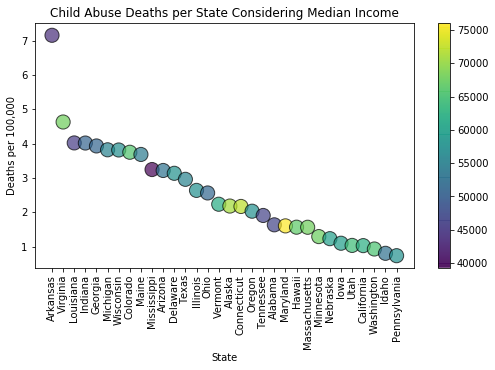

In [37]:

# Set the axes
x = df_f.index
y = df_f.Deaths_per_capita*100000
z = df_f.Median_Salary

# Size it
fig = plt.gcf()
fig.set_size_inches(8.5, 4.5)

# Plot it
plt.scatter(x, y,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z,)
plt.xticks(rotation='vertical')
plt.xlabel("State")
plt.ylabel("Deaths per 100,000")
plt.title("Child Abuse Deaths per State Considering Median Income")
plt.colorbar()
plt.show()

# Save it
fig.savefig('abuse_deaths.png', dpi=100)
